In [301]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## 1. Импорт и  первичный анализ данных

In [302]:
data = pd.read_csv('data/flats.zip')
data.head()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0


Проверим данные на пропуски

In [303]:
data.isna().sum()

Unnamed: 0    0
price_doc     0
full_sq       0
life_sq       0
num_room      0
kitch_sq      0
dtype: int64

In [304]:
data.describe()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6042.000000,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,19846.990070,8.750423e+06,53.374545,33.198941,1.997021,7.391096
std,6081.011373,6.277290e+06,24.011941,20.190005,0.889523,3.806198
min,8056.000000,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,14573.250000,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,19871.500000,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,25147.750000,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,30470.000000,9.512250e+07,637.000000,637.000000,17.000000,96.000000


Есть подозрение, что "Unnamed: 0" это столбец ранее использовавшийся как индекс. Для подтверждения проверим последние строки.

In [305]:
data.tail()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
6037,30462,10544070,47,30.0,1.0,10.0
6038,30463,12000000,56,29.0,2.0,11.0
6039,30467,25000000,86,59.0,4.0,10.0
6040,30469,13500000,64,32.0,2.0,11.0
6041,30470,5600000,43,28.0,2.0,6.0


Удаляем столбец "Unnamed: 0".

In [306]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,price_doc,full_sq,life_sq,num_room,kitch_sq
0,2750000,11,11.0,1.0,12.0
1,7100000,45,27.0,2.0,6.0
2,11700000,77,50.0,3.0,8.0
3,10400000,56,29.0,2.0,10.0
4,6200000,31,21.0,1.0,5.0


## 2. Разведывательный анализ данных

Рассмотрим распределение данных.

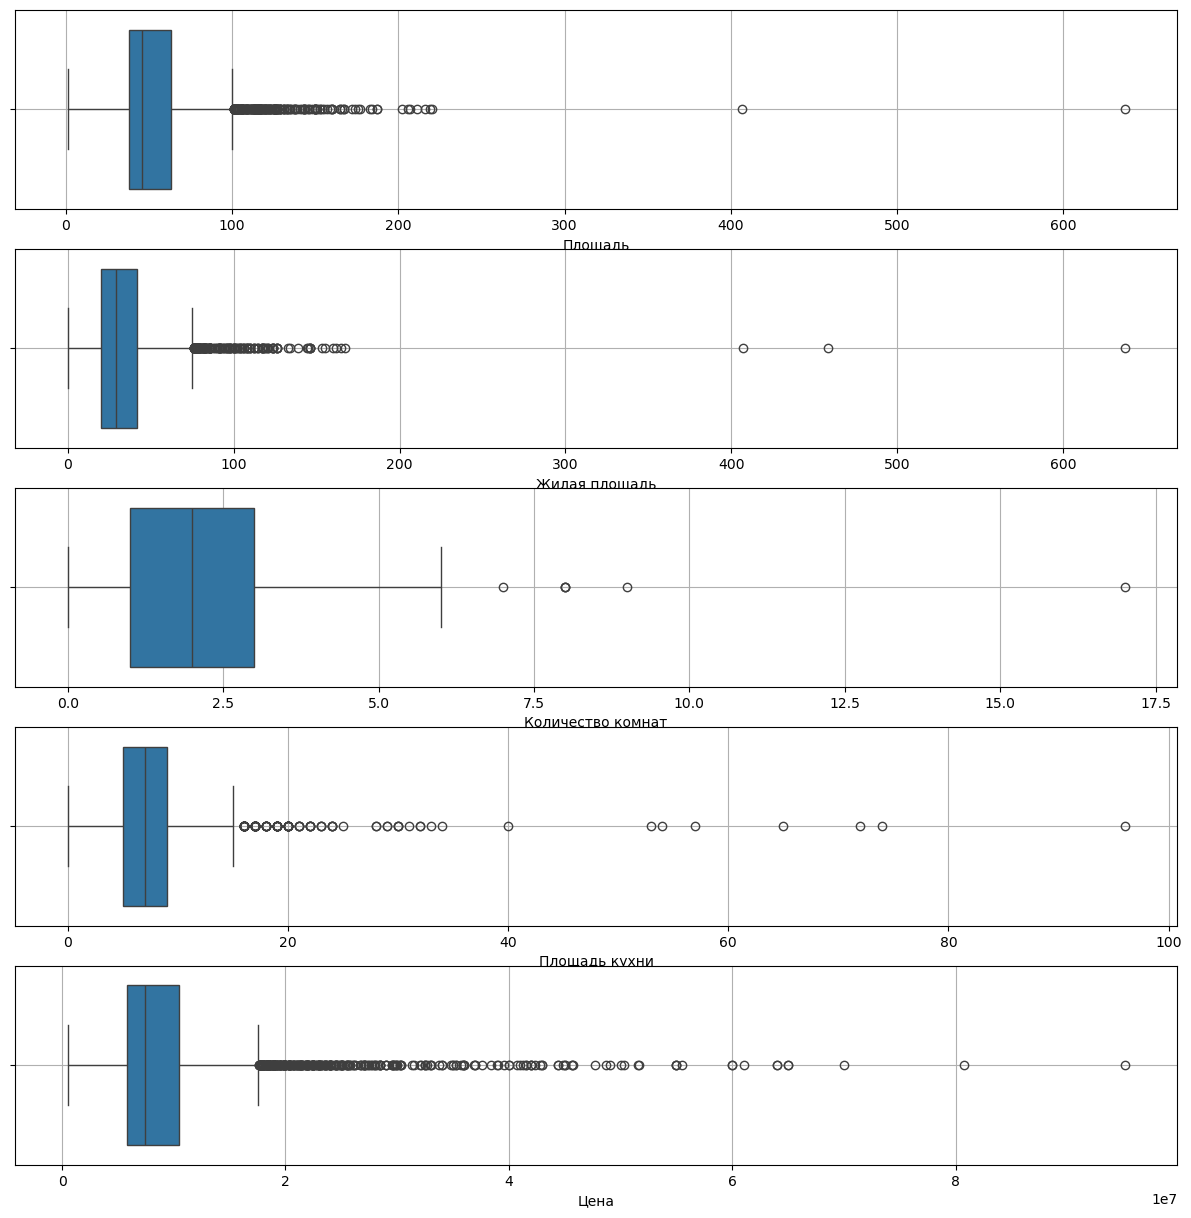

In [307]:
fig, axes = plt.subplots(nrows=5, figsize=(15, 15))

sns.boxplot(x=data.full_sq, ax=axes[0])
axes[0].set(xlabel="Площадь")
axes[0].grid()

sns.boxplot(x=data.life_sq, ax=axes[1])
axes[1].set(xlabel="Жилая площадь")
axes[1].grid()

sns.boxplot(x=data.num_room, ax=axes[2])
axes[2].set(xlabel="Количество комнат")
axes[2].grid()

sns.boxplot(x=data.kitch_sq, ax=axes[3])
axes[3].set(xlabel="Площадь кухни")
axes[3].grid()

sns.boxplot(x=data.price_doc, ax=axes[4])
axes[4].set(xlabel="Цена")
axes[4].grid()

Распределение можно считать нормальным. Однако есть выбросы. Предлагаю их удалить.

In [308]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=True):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [309]:
_, data = outliers_iqr_mod(data, 'full_sq', log_scale=False)
_, data = outliers_iqr_mod(data, 'life_sq', log_scale=False)
_, data = outliers_iqr_mod(data, 'num_room', log_scale=False)
_, data = outliers_iqr_mod(data, 'kitch_sq', log_scale=False)

data.reset_index(inplace=False, drop=True)
data.describe()

,price_doc,full_sq,life_sq,num_room,kitch_sq
count,5.682000e+03,5682.000000,5682.000000,5682.000000,5682.000000
mean,7.910484e+06,49.603661,30.324710,1.932066,7.046639
std,4.178513e+06,15.972249,11.750651,0.800653,2.432856
min,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,5.700000e+06,38.000000,20.000000,1.000000,5.000000
50%,7.200000e+06,45.000000,29.000000,2.000000,7.000000
75%,9.800000e+06,59.000000,39.000000,2.750000,9.000000
max,3.900000e+07,100.000000,70.000000,6.000000,15.000000


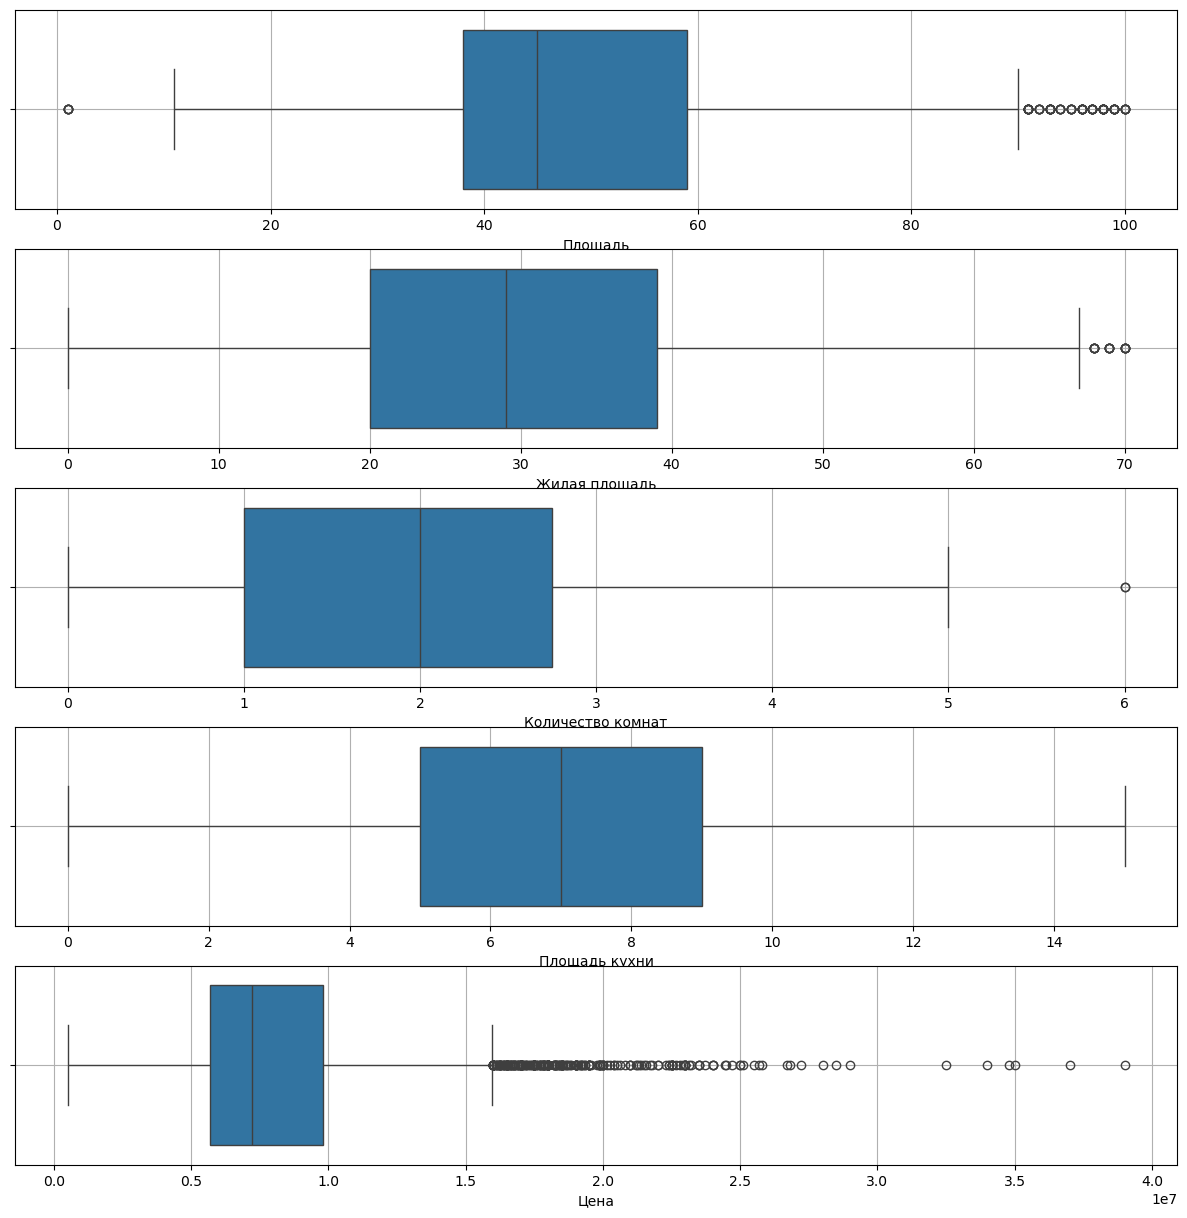

In [310]:
fig, axes = plt.subplots(nrows=5, figsize=(15, 15))

sns.boxplot(x=data.full_sq, ax=axes[0])
axes[0].set(xlabel="Площадь")
axes[0].grid()

sns.boxplot(x=data.life_sq, ax=axes[1])
axes[1].set(xlabel="Жилая площадь")
axes[1].grid()

sns.boxplot(x=data.num_room, ax=axes[2])
axes[2].set(xlabel="Количество комнат")
axes[2].grid()

sns.boxplot(x=data.kitch_sq, ax=axes[3])
axes[3].set(xlabel="Площадь кухни")
axes[3].grid()

sns.boxplot(x=data.price_doc, ax=axes[4])
axes[4].set(xlabel="Цена")
axes[4].grid()

## 3. Предобработка данных

In [311]:
s_scaler = MinMaxScaler()

# кодируем исходный датасет
X = pd.DataFrame(s_scaler.fit_transform(data[['full_sq', 'life_sq', 'num_room', 'kitch_sq']]), columns=['full_sq', 'life_sq', 'num_room', 'kitch_sq'])

X.describe()

,full_sq,life_sq,num_room,kitch_sq
count,5682.000000,5682.000000,5682.000000,5682.000000
mean,0.490946,0.433210,0.322011,0.469776
std,0.161336,0.167866,0.133442,0.162190
min,0.000000,0.000000,0.000000,0.000000
25%,0.373737,0.285714,0.166667,0.333333
50%,0.444444,0.414286,0.333333,0.466667
75%,0.585859,0.557143,0.458333,0.600000
max,1.000000,1.000000,1.000000,1.000000


In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, data.price_doc, test_size = 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3977, 4), (1705, 4), (3977,), (1705,))

<Axes: xlabel='price_doc', ylabel='Count'>

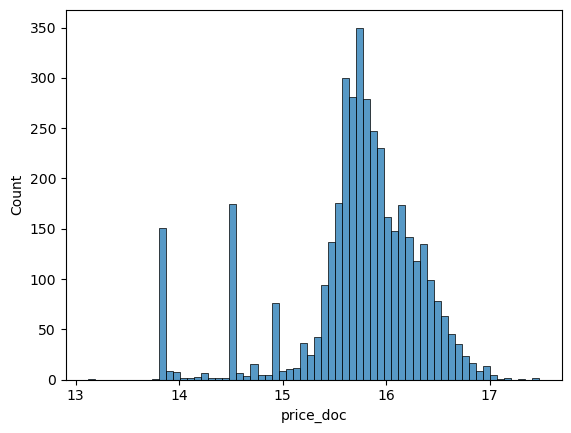

In [313]:
y_train = np.log(y_train)
sns.histplot(y_train)

In [314]:
y_train

5719    16.677711
2177    15.555977
3743    16.142788
5876    15.869634
2473    15.503849
          ...    
3997    15.955577
5505    16.660420
5541    15.925724
5722    15.782623
902     14.508658
Name: price_doc, Length: 3977, dtype: float64

## 3. Построение байесовской модели линейной регресссисии

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, slope, sigma]


c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, slope, sigma]


c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


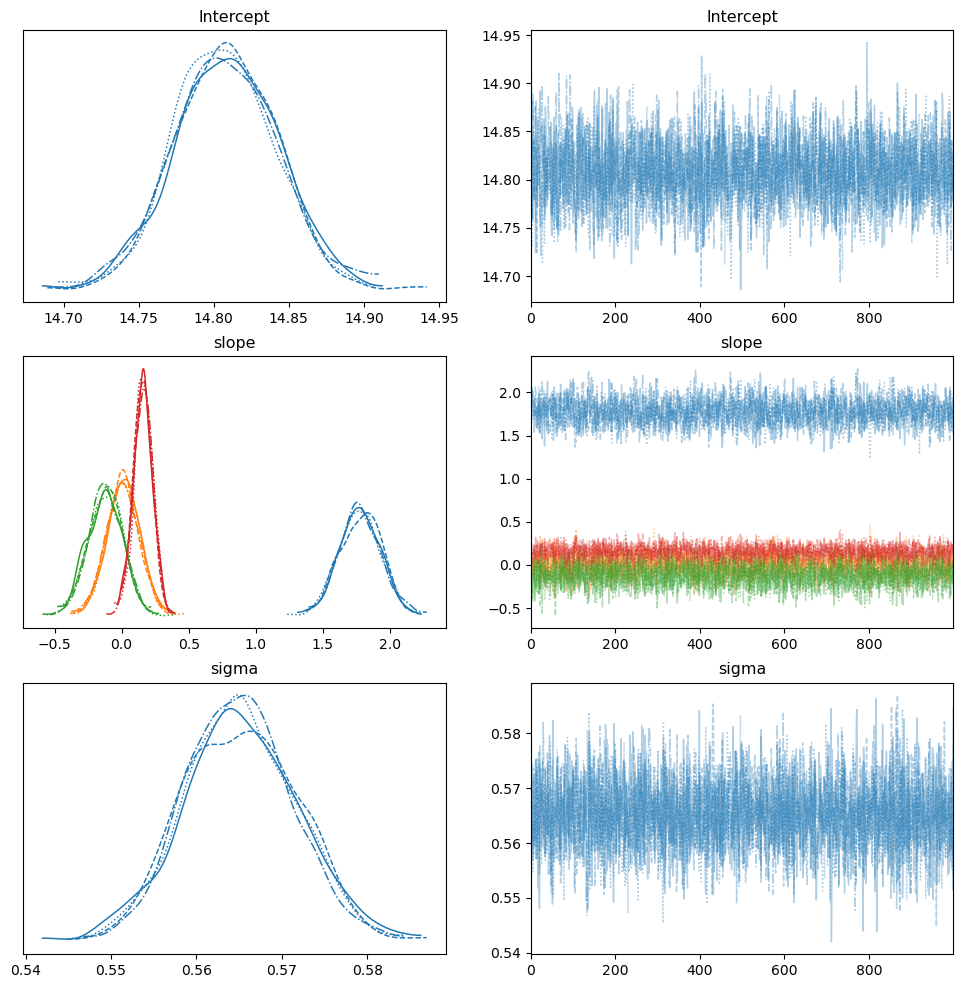

In [315]:
with pm.Model() as bayas_linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sigma = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sigma = 10, shape=4)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sigma = 10)
    
    # Estimate of mean
    mean = (intercept + 
            slope[0] * X_train.full_sq +
            slope[1] * X_train.life_sq +
            slope[2] * X_train.num_room +
            slope[3] * X_train.kitch_sq)
    
    # Observed values
    Y_obs = pm.Normal('Y_obs',
                      mu = mean,
                      sigma = sigma,
                      observed = y_train)

    # Posterior distribution
    linear_trace = pm.sample()


    
    # Posterior distribution
    linear_trace = pm.sample(1000)
    
    pm.plot_trace(linear_trace, figsize = (12, 12))

In [316]:
pm.summary(linear_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,14.808,0.034,14.744,14.872,0.001,0.001,2945.0,2751.0,1.0
slope[0],1.778,0.152,1.498,2.062,0.004,0.002,1880.0,2208.0,1.0
slope[1],0.011,0.121,-0.208,0.247,0.003,0.002,2214.0,2459.0,1.0
slope[2],-0.123,0.128,-0.368,0.107,0.002,0.002,2694.0,2758.0,1.0
slope[3],0.159,0.071,0.025,0.292,0.002,0.001,1943.0,2071.0,1.0
sigma,0.565,0.006,0.553,0.577,0.000,0.000,3762.0,2411.0,1.0


## 4. Построение классической модели линейной регрессии

In [317]:
classic_linear_model = LinearRegression()
classic_linear_model.fit(X_train, y_train)

LinearRegression()

In [318]:
classic_linear_model.coef_, classic_linear_model.intercept_

(array([ 1.77487376,  0.01295067, -0.12293709,  0.15958903]),
 np.float64(14.808394477532824))

## 5. Сравнение коэффициентов и выводы

Коэффициенты байасовской модели

In [319]:
model_coef = pm.summary(linear_trace)['mean']

Коэффициенты классической модели

In [320]:
pd.Series([classic_linear_model.intercept_, *classic_linear_model.coef_], 
          index=['Intercept', 'slope[0]', 'slope[1]', 'slope[2]', 'slope[3]']) 

Intercept    14.808394
slope[0]      1.774874
slope[1]      0.012951
slope[2]     -0.122937
slope[3]      0.159589
dtype: float64

Сравним показатели модели на mean_squared_error

In [321]:
bayas_y_test_pred = np.exp(model_coef['Intercept'] + \
            model_coef['slope[0]'] * X_test.full_sq +\
            model_coef['slope[1]'] * X_test.life_sq +\
            model_coef['slope[2]'] * X_test.num_room +\
            model_coef['slope[3]'] * X_test.kitch_sq)

In [322]:
classic_y_test_pred = classic_linear_model.predict(X_test)

In [323]:
bayas_mae = mean_absolute_error(y_test, bayas_y_test_pred)
classic_mae = mean_absolute_error(y_test, classic_y_test_pred)

print('MAE Bayas:', bayas_mae)
print('MAE classic:', classic_mae)
print('MAE classic/MAE Bayas:', classic_mae/bayas_mae)

MAE Bayas: 2561973.763378811
MAE classic: 7976004.522654726
MAE classic/MAE Bayas: 3.113226464948541


**Вывод:** Коэфициенты классической линейной модели и байасовской получились довольно похожи. Однако средняя ошибка байасовской модели в 3.115 раза меньше чем ошибка классической модели.